### Import packages

In [31]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_columns", None)

### Set working directory

In [32]:
# Print working directory
cwd = os.getcwd()
print(f'Directory: {cwd}')

# Change working directory
os.chdir('/Users/tyler/OneDrive/Documents/Python/NBA')

# Print working directory
cwd = os.getcwd()
print(f'Directory: {cwd}')

Directory: c:\Users\tyler\OneDrive\Documents\Python\NBA
Directory: c:\Users\tyler\OneDrive\Documents\Python\NBA


## Exploratory Data Analysis

### Import data

In [33]:
totals_df = pd.read_csv('backend/data/totals/game_totals.csv').drop(['Unnamed: 0'], axis=1)[['date', 'visitor', 'home', '3p']]
predict_df = pd.read_csv('backend/predictions/3p_predictions.csv').drop(['Unnamed: 0'], axis=1)

# Convert date to datetime
totals_df['date'] = pd.to_datetime(totals_df['date'])
predict_df['date'] = pd.to_datetime(predict_df['date'])

# Total 3pt by both teams
totals_df = totals_df.groupby(['date', 'visitor', 'home']).sum()

# Merge datafrtames
df = pd.merge(predict_df, totals_df, left_on=['date', 'visitor', 'home'], right_on=['date', 'visitor', 'home'], how='left')
df = df.drop_duplicates(['date', 'visitor', 'home']).dropna(axis=0)

# Seperate current games from past games
today_df = df[df['3p'] == 0]
df = df[df['3p'] > 0]

# Day of week
df['dow_name'] = df['date'].dt.day_name()

# Sort by date 
df = df.sort_values(['date'], ascending=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 419 entries, 0 to 433
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              419 non-null    datetime64[ns]
 1   visitor           419 non-null    object        
 2   home              419 non-null    object        
 3   linear            419 non-null    float64       
 4   decision_tree     419 non-null    float64       
 5   gradient_boosted  419 non-null    float64       
 6   neural_network    419 non-null    float64       
 7   random_forest     419 non-null    float64       
 8   line              419 non-null    float64       
 9   avg               419 non-null    float64       
 10  over              419 non-null    float64       
 11  under             419 non-null    object        
 12  3p                419 non-null    float64       
 13  dow_name          419 non-null    object        
dtypes: datetime64[ns](1), floa

## Feauture Engineer Model's Perforamnces

In [34]:
def myround(x, base=.5):
    return base * round(x/base)

In [35]:
models = ['linear', 'decision_tree', 'gradient_boosted', 'neural_network', 'random_forest', 'avg']
for model in models:
    df[model + '_predict'] = np.where(df[model] > df['line'], 'o', 'u')
    
    # Compute if model predicted correctly
    df[model + '_hit'] = ((df['3p'] > df['line']) & (df[model] > df['line'])) | \
                            ((df['3p'] < df['line']) & (df[model] < df['line']))
    
    # Compute models profit per bet
    df[model + '_potential_profit'] = np.where(
        df[model] > df['line'], 
        df['over'].apply(float), 
        df['under'].apply(float)
    )
    
    df[model + '_potential_profit'] = np.where(
        df[model + '_potential_profit'] > 0, df[model + '_potential_profit'] / 100, -100 / df[model + '_potential_profit'])
    
    df[model + '_profit'] = np.where(df[model + '_hit'], df[model + '_potential_profit'], -1)
    
    # Compute difference between line and prediction
    df[model + '_diff'] = myround(df[model] - df['line']).abs()
    
    # Compute accumulative profit overtime
    df[model + '_accumulative_profit'] = df[model + '_profit'].cumsum()

df.tail()

,date,visitor,home,linear,decision_tree,gradient_boosted,neural_network,random_forest,line,avg,over,under,3p,dow_name,linear_predict,linear_hit,linear_potential_profit,linear_profit,linear_diff,linear_accumulative_profit,decision_tree_predict,decision_tree_hit,decision_tree_potential_profit,decision_tree_profit,decision_tree_diff,decision_tree_accumulative_profit,gradient_boosted_predict,gradient_boosted_hit,gradient_boosted_potential_profit,gradient_boosted_profit,gradient_boosted_diff,gradient_boosted_accumulative_profit,neural_network_predict,neural_network_hit,neural_network_potential_profit,neural_network_profit,neural_network_diff,neural_network_accumulative_profit,random_forest_predict,random_forest_hit,random_forest_potential_profit,random_forest_profit,random_forest_diff,random_forest_accumulative_profit,avg_predict,avg_hit,avg_potential_profit,avg_profit,avg_diff,avg_accumulative_profit
429,2022-05-24,Golden State Warriors,Dallas Mavericks,25.0,28.0,24.0,23.0,25.0,24.5,25.0,-140.0,105,30.0,Tuesday,o,True,0.714286,0.714286,0.5,-15.743506,o,True,0.714286,0.714286,3.5,12.850336,u,False,1.050000,-1.000000,0.5,-0.015940,u,False,1.050000,-1.000000,1.5,-3.746152,o,True,0.714286,0.714286,0.5,21.918072,o,True,0.714286,0.714286,0.5,13.093621
430,2022-05-25,Boston Celtics,Miami Heat,22.0,24.0,21.0,21.0,24.0,26.5,22.4,-120.0,-110,17.0,Wednesday,u,True,0.909091,0.909091,4.5,-14.834415,u,True,0.909091,0.909091,2.5,13.759427,u,True,0.909091,0.909091,5.5,0.893151,u,True,0.909091,0.909091,5.5,-2.837061,u,True,0.909091,0.909091,2.5,22.827163,u,True,0.909091,0.909091,4.0,14.002712
431,2022-05-26,Dallas Mavericks,Golden State Warriors,25.0,28.0,25.0,20.0,25.0,27.5,24.6,-115.0,-115,31.0,Thursday,u,False,0.869565,-1.000000,2.5,-15.834415,o,True,0.869565,0.869565,0.5,14.628992,u,False,0.869565,-1.000000,2.5,-0.106849,u,False,0.869565,-1.000000,7.5,-3.837061,u,False,0.869565,-1.000000,2.5,21.827163,u,False,0.869565,-1.000000,3.0,13.002712
432,2022-05-27,Miami Heat,Boston Celtics,22.0,24.0,20.0,21.0,24.0,21.5,22.2,-145.0,105,26.0,Friday,o,True,0.689655,0.689655,0.5,-15.144760,o,True,0.689655,0.689655,2.5,15.318647,u,False,1.050000,-1.000000,1.5,-1.106849,u,False,1.050000,-1.000000,0.5,-4.837061,o,True,0.689655,0.689655,2.5,22.516818,o,True,0.689655,0.689655,0.5,13.692367
433,2022-05-29,Boston Celtics,Miami Heat,22.0,22.0,15.0,21.0,24.0,21.5,20.8,-115.0,-115,17.0,Sunday,o,False,0.869565,-1.000000,0.5,-16.144760,o,False,0.869565,-1.000000,0.5,14.318647,u,True,0.869565,0.869565,6.5,-0.237283,u,True,0.869565,0.869565,0.5,-3.967495,o,False,0.869565,-1.000000,2.5,21.516818,u,True,0.869565,0.869565,0.5,14.561932


# Model's

### Day of week profit over time

,dow_name,random_forest_profit
1,Monday,16.457973
0,Friday,13.050146
5,Tuesday,3.597614
6,Wednesday,3.562206
4,Thursday,1.483141
2,Saturday,-0.837443
3,Sunday,-15.796819


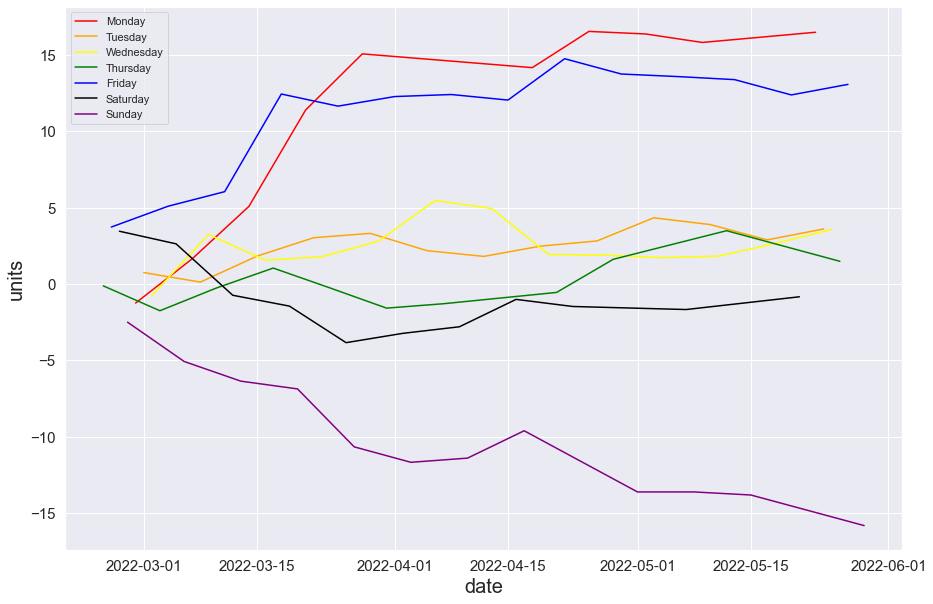

In [36]:
# seaborn formatting
sns.set(rc={"figure.figsize":(15, 10)})
sns.set_palette('bright', 8)
plt.xlabel('date', fontsize=20)
plt.ylabel('units', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'black', 'purple']
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day, color in zip(days, colors):
    dow_df = df.groupby(['date', 'dow_name']).aggregate('sum').reset_index()
    dow_df = dow_df[dow_df['dow_name'] == day]
    dow_df['profit'] = dow_df['random_forest_profit'].cumsum()
    
    sns.lineplot(data=dow_df, x='date', y='profit', color=color, label=day)


dow_df = df.groupby(['dow_name']).aggregate('sum').reset_index().sort_values(['random_forest_profit'], ascending=False)
dow_df[['dow_name', 'random_forest_profit']]

### Profit Analysis

,model,record,accuracy,profit
4,random_forest,243 - 176,58,21.52
5,avg,241 - 178,58,14.56
1,decision_tree,240 - 179,57,14.32
2,gradient_boosted,233 - 186,56,-0.24
3,neural_network,229 - 190,55,-3.97
0,linear,225 - 194,54,-16.14


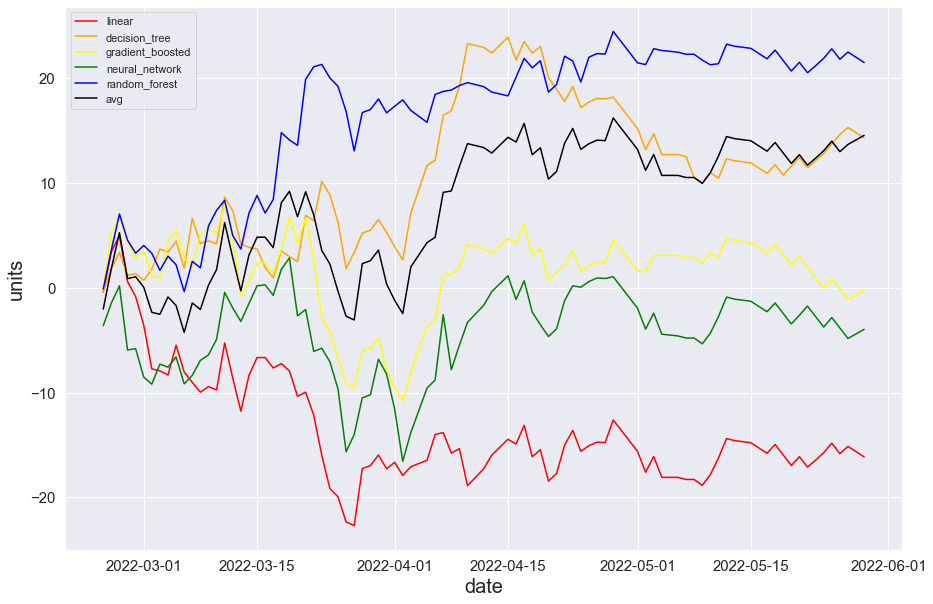

In [37]:
# seaborn formatting
sns.set(rc={"figure.figsize":(15, 10)})
plt.xlabel('date', fontsize=20)
plt.ylabel('units', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Totals
totals = {'model': [], 'record': [], 'accuracy': [], 'profit': []}


colors = ['red', 'orange', 'yellow', 'green', 'blue', 'black']
for model, col in zip(models, colors):
    # Line graph
    sns.lineplot(data=df.groupby(['date']).sum(), x='date', y=df.groupby(['date']).sum()[f'{model}_profit'].cumsum(), color=col, label=model)
    
    # Totals
    profit = df[model + '_profit'].sum()
    correct = df[df[model + '_hit'] == True][model + '_hit'].count()
    wrong = df[df[model + '_hit'] == False][model + '_hit'].count()
    
    totals['model'].append(model)
    totals['record'].append(f'{correct} - {wrong}')
    totals['accuracy'].append(round((correct / (correct + wrong)) * 100))
    totals['profit'].append(round(profit, 2))
    

totals = pd.DataFrame(totals).sort_values(['profit', 'accuracy'], ascending=False)
totals

### Risk Management

In [38]:
def risk(diff):
    # return 1
    if abs(diff) <= .5:
        return 1
    elif abs(diff) <= 1.5:
        return 1.5
    elif abs(diff) <= 2.5:
        return 2
    elif abs(diff) <= 3.5:
        return 2.5
    elif abs(diff) >= 4.5:
        return 3

In [39]:
for model in models:
    df[f'{model}_risk'] = df[f'{model}_diff'].apply(risk)
    df[f'{model}_risk_profit'] = np.where(
        df[f'{model}_hit'],
        df[f'{model}_risk'] * df[f'{model}_potential_profit'],
        df[f'{model}_risk'] * -1
    )

    diff_df = df.groupby([f'{model}_diff'])[[f'{model}_profit', f'{model}_hit']].aggregate(['sum', 'count'])
    diff_df['accuracy'] = round(100 * diff_df[(f'{model}_hit', 'sum')] / diff_df[(f'{model}_hit', 'count')])
    print(f'{model}:')
    print(f'\t{diff_df}')


linear:
	            linear_profit       linear_hit       accuracy
                      sum count        sum count         
linear_diff                                              
0.5            -20.413184   217        107   217     49.0
1.5             -0.637311   137         78   137     57.0
2.5              2.454913    54         32    54     59.0
3.5              0.401190     6          4     6     67.0
4.5              1.249631     4          3     4     75.0
5.5              0.800000     1          1     1    100.0
decision_tree:
	                   decision_tree_profit       decision_tree_hit       accuracy
                                    sum count               sum count         
decision_tree_diff                                                            
0.5                           15.203126   202               117   202     58.0
1.5                           -0.908270   128                72   128     56.0
2.5                            5.770075    47             

,model,record,accuracy,profit
4,random_forest,243 - 176,58,24.49
1,decision_tree,240 - 179,57,7.82
2,gradient_boosted,233 - 186,56,7.69
5,avg,241 - 178,58,7.12
0,linear,225 - 194,54,-9.31
3,neural_network,229 - 190,55,-13.72


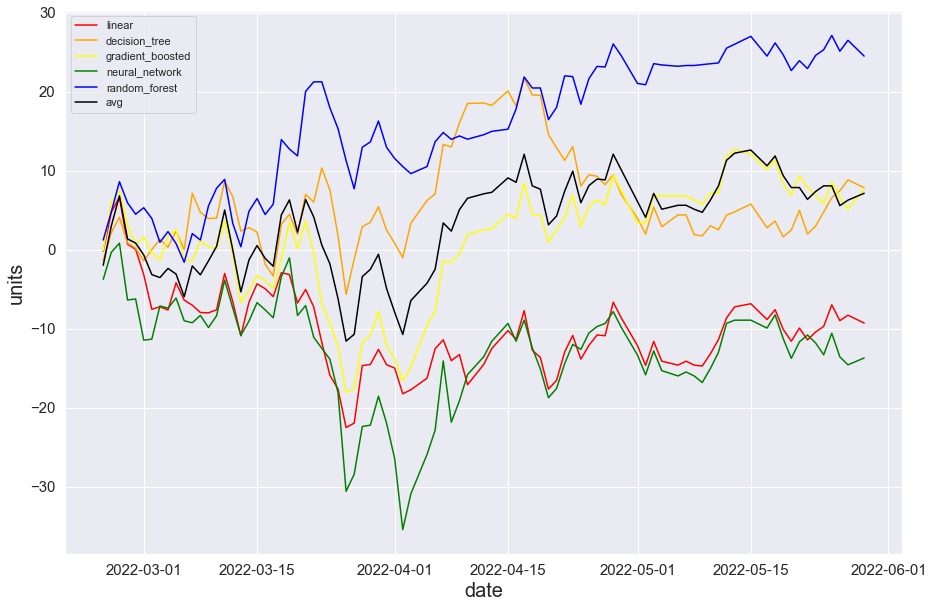

In [40]:
# seaborn formatting
sns.set(rc={"figure.figsize":(15, 10)})
plt.xlabel('date', fontsize=20)
plt.ylabel('units', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Totals
totals = {'model': [], 'record': [], 'accuracy': [], 'profit': []}

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'black']
for model, col in zip(models, colors):
    # Line graph
    sns.lineplot(data=df.groupby(['date']).sum(), x='date', y=df.groupby(['date']).sum()[f'{model}_risk_profit'].cumsum(), color=col, label=model)
    
    # Totals
    profit = df[model + '_risk_profit'].sum()
    correct = df[df[model + '_hit'] == True][model + '_hit'].count()
    wrong = df[df[model + '_hit'] == False][model + '_hit'].count()
    
    totals['model'].append(model)
    totals['record'].append(f'{correct} - {wrong}')
    totals['accuracy'].append(round((correct / (correct + wrong)) * 100))
    totals['profit'].append(round(profit, 2))
    

totals = pd.DataFrame(totals).sort_values(['profit', 'accuracy'], ascending=False)
totals